# Research the correlation between PFT and torso

In [2]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json
import matplotlib
import copy
from scipy.stats import pearsonr



/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
pft_fpath = '/home/jjia/data/dataset/lung_function/SScBaseline_PFT_anonymized_with_percent.xlsx'  # id from 0068800 to 99..., total 333 cases
label_excel = pd.read_excel(pft_fpath, engine='openpyxl')
label_excel = label_excel.sort_values(by=['subjectID'])


## Calculate torso/lung/vessel volume, and perc85 density, and save them to a file

In [4]:
data_dir = '/home/jjia/data/dataset/lung_function/iso1.5'

torso_files = sorted(glob(data_dir + '/*Torso.nii.gz'))
lung_files = sorted(glob(data_dir + '/*LungMask.nii.gz'))
vessel_files = sorted(glob(data_dir + '/*GcVessel.nii.gz'))


In [65]:
torso_ids = [i.split('/')[-1][12:19] for i in torso_files]
lung_ids =  [i.split('/')[-1][12:19] for i in lung_files]

In [66]:
valid_torso_files = []
for i,j in zip(torso_ids, torso_files):
    if i in lung_ids:
        valid_torso_files.append(j)
len(valid_torso_files)

317

In [68]:
def volumes(files):
    volume_ls = []
    for i in tqdm(files):
        lung, ori, sp = load_itk(i, require_ori_sp=True)
        lung[lung>0] = 1
        voxel_size = sp[0] * sp[1] * sp[2]
        # print(f'sp for {i} is {sp}')
        # print(f'voxelsize for {i}', voxel_size)
        lung_volume = np.sum(lung) * voxel_size / (10**6)
        volume_ls.append([i.split('SSc_patient_')[-1][:7], lung_volume])
    return volume_ls


In [69]:
torso_volumes, lung_volumes, vessel_volumes = map(volumes, [valid_torso_files, lung_files, vessel_files])

100%|██████████| 317/317 [02:00<00:00,  2.63it/s]


In [71]:
all_pat_id = []
all_volumes = [[] for i in range(len(torso_volumes))]
flag = True
for idx, volumes in enumerate([torso_volumes, lung_volumes, vessel_volumes]):
    global flag
    if flag:
        for i in volumes:
            all_pat_id.append([i[0]])
        flag = False
    for idx2, j in enumerate(volumes):
        all_volumes[idx2].append(j[1])


In [72]:
all_pat_id = np.array(all_pat_id)

In [75]:
all_volumes = np.array([np.array(i) for i in all_volumes])

In [91]:
# Density85
data_dir = '/home/jjia/data/dataset/lung_function/iso1.5'

ct_files = [i.replace('_LungMask', '') for i in lung_files]

density85_ls = []
for ct_fpath, lung_fpath in tqdm(zip(ct_files, lung_files)):
    ct, ori, sp = load_itk(ct_fpath, require_ori_sp=True)
    lungmask = load_itk(lung_fpath)
    ct = ct[lungmask>0].flatten()
    lung_volume = np.percentile(ct, 85)  # 85 instead of 75! I made a mistake here for a long time
    density85_ls.append(lung_volume)
density85 = np.array(density85_ls)

317it [04:45,  1.11it/s]


In [479]:
# alpha and beta using Zhiwei's data
alpha_beta_df = pd.read_csv("/home/jjia/data/dataset/lung_function/alpha_beta_summary.csv")

alpha_beta = []
for id in lung_ids:
    row_ab = alpha_beta_df[alpha_beta_df['pat_id']==int(id)]
    alpha_beta.append([row_ab.iloc[0,1], row_ab.iloc[0,2]])
alpha_beta = np.array(alpha_beta)


In [480]:
all = np.concatenate((all_pat_id, all_volumes, density85.reshape(len(density85_ls),1), alpha_beta), axis=1)
df = pd.DataFrame(all, columns=['pat_id', 'torso_volume', 'lung_volume', 'vessel_volume', 'density85', 'alpha','beta'])
df.set_index('pat_id')

,torso_volume,lung_volume,vessel_volume,density85,alpha,beta
pat_id,,,,,,
0068800,18.062328375,5.26107825,0.448335,-772.0,-1.073,9.5845
0127512,16.196189625,3.332836125,0.3484485,-666.0,-1.0994,9.3001
0139552,19.561759875,6.198379875,0.246648375,-797.0,-1.4488,10.426
0143788,21.083999625,3.890804625,0.64264725,-504.0,-1.3389,10.9858
0152440,22.894444125,4.1376015,0.193714875,-773.0,-1.5033,10.1955
...,...,...,...,...,...,...
9523013,22.628491102159025,5.512411125,0.509351625,-679.0,-1.4441,10.7688
9662556,19.240668831209256,4.372666875,0.20589525,-710.0,-1.7964,11.083
9861781,23.546867006364668,5.094376875,0.54215325,-743.0,-1.1365,10.2187


In [481]:
df_new = pd.DataFrame(columns=['PatID', 'Torso-V', 'Lung-V','Vessel-V', 'Density85', 'alpha', 'beta', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])


In [482]:
i = 0
for idx, row in label_excel.iterrows():
    id = row['subjectID'].split('SSc_patient_')[-1][:7]
    if id in [i[0] for i in all_pat_id]:
        row_v = df[df['pat_id']==id]
        a = row_v['density85'].iloc[0]
        new_row = [id, row_v['torso_volume'].iloc[0], row_v['lung_volume'].iloc[0], row_v['vessel_volume'].iloc[0], row_v['density85'].iloc[0], row_v['alpha'].iloc[0], row_v['beta'].iloc[0],   row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
        df_new.loc[i] = new_row
        i += 1


In [484]:
for name in df_new.columns:
    if name!='PatID':
        df_new[name].replace('', np.nan, inplace=True)  # exclude 3 rows with NV or empty cells
        df_new[name].replace('NV', np.nan, inplace=True)

        df_new.dropna(subset=[name], inplace=True)
        df_new[name] = df_new[name].astype(float)

In [485]:
df_new.to_csv(file_fpath)

# You can start hear to load all biomarker excel data directly 

In [5]:
file_fpath = 'all_biomarkers_correct3.csv'

In [6]:
df_new=pd.read_csv(file_fpath)

In [7]:
def get_corr_p_matrix(df_new, biomarker_names, pft_names):
    # 计算相关系数和显著性水平
    corr_np = np.zeros((len(biomarker_names), len(pft_names)))
    p_np = np.zeros((len(biomarker_names), len(pft_names)))
    for i, col1 in enumerate(biomarker_names):
        for j, col2 in enumerate(pft_names):
            corr, p_value = pearsonr(df_new[col1], df_new[col2])
            corr_np[i,j] = corr
            p_np[i,j] = p_value
            # print(f'{col1} 和 {col2} 的相关系数：{corr:.3f}，显著性水平：{p_value:.3f}')
    return corr_np, p_np

In [8]:
# 指定需要计算相关系数的列
biomarker_names = ['Lung-V', 'Vessel-V', 'Density85', 'alpha', 'beta']
pft_names = ['DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']

In [9]:
# training and valid data
first_ts_pat_id = 7957098
train_df = df_new.loc[df_new['PatID'] < first_ts_pat_id]
test_df = df_new.loc[df_new['PatID'] >= first_ts_pat_id]

corr_np_train, p_np_train = get_corr_p_matrix(train_df, biomarker_names, pft_names)
corr_np_test, p_np_test = get_corr_p_matrix(test_df, biomarker_names, pft_names)
corr_np_all, p_np_all = get_corr_p_matrix(df_new, biomarker_names, pft_names)


In [10]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def corr_p_imshow(corr_matrix, p_matrix, rows= ['Torso-V', 'Lung-V', 'Vessel-V', 'Density85', 'alpha', 'beta'], cols= ['DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']):
    # 设置数据
    assert corr_matrix.shape == p_matrix.shape
    assert corr_matrix.shape[0] == len(rows)
    assert corr_matrix.shape[1] == len(cols)

    # 定义自定义的colormap
    cmap_p = matplotlib.colors.ListedColormap(['darkgreen', 'green', 'yellowgreen', '#ffffe4'])
    bounds_p = [0, 0.001, 0.01, 0.05, 1]
    norm_p = matplotlib.colors.BoundaryNorm(bounds_p, cmap_p.N)


    
    # 创建figure和两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 绘制第一个子图
    im1 = ax1.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

    # 在每个单元格中添加文本
    for i in range(len(rows)):
        for j in range(len(cols)):
            text = ax1.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center')#, fontsize=12

    # 添加左图的colorbar
    cbar1 = ax1.figure.colorbar(im1, ax=ax1, shrink=0.8)
    # 绘制左边的colorbar
    # cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    # cbar1.ax.yaxis.set_ticks_position('left')
    # cbar1.set_label('Correlation Coefficient (R)')

    # 添加坐标轴标签和标题
    ax1.set_xticks(range(len(cols)))
    ax1.set_xticklabels(cols, rotation=30, ha='right')
    ax1.set_yticks(range(len(rows)))
    ax1.set_yticklabels(rows)
    ax1.set_title('Correlation Matrix (R)')

    # 绘制第二个子图
    im2 = ax2.imshow(p_matrix, cmap=cmap_p, norm=norm_p)


    # 在每个单元格中添加文本
    for i in range(len(rows)):
        for j in range(len(cols)):
            text = ax2.text(j, i, f'{p_matrix[i, j]:.2f}', ha='center', va='center')#, fontsize=12
            
    # 添加右图的colorbar
    cbar2 = ax2.figure.colorbar(im2, ax=ax2, cmap=cmap_p, norm=norm_p, boundaries=bounds_p, ticks=bounds_p, shrink=0.8)


    # 添加坐标轴标签和标题
    ax2.set_xticks(range(len(cols)))
    ax2.set_xticklabels(cols, rotation=30, ha='right')
    ax2.set_yticks(range(len(rows)))
    ax2.set_yticklabels(rows)
    ax2.set_title('Significance Matrix (P)')


    plt.tight_layout()
    plt.show()


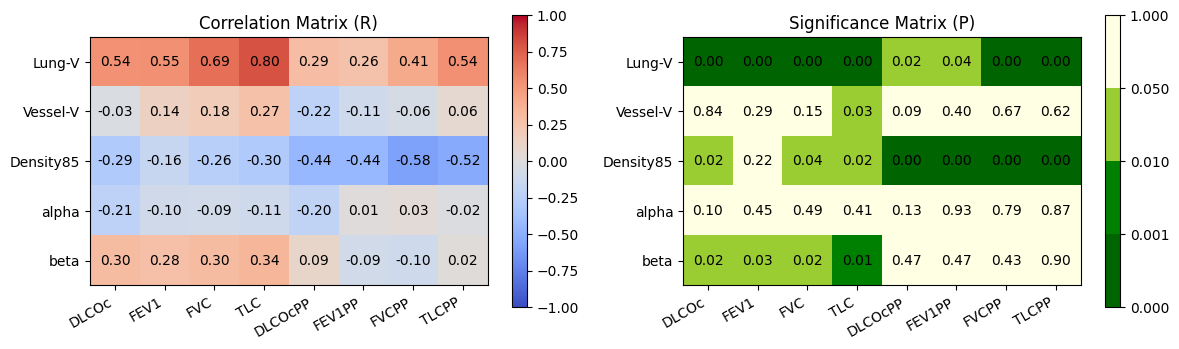

In [11]:
corr_p_imshow(corr_np_test, p_np_test, rows=biomarker_names, cols=pft_names)

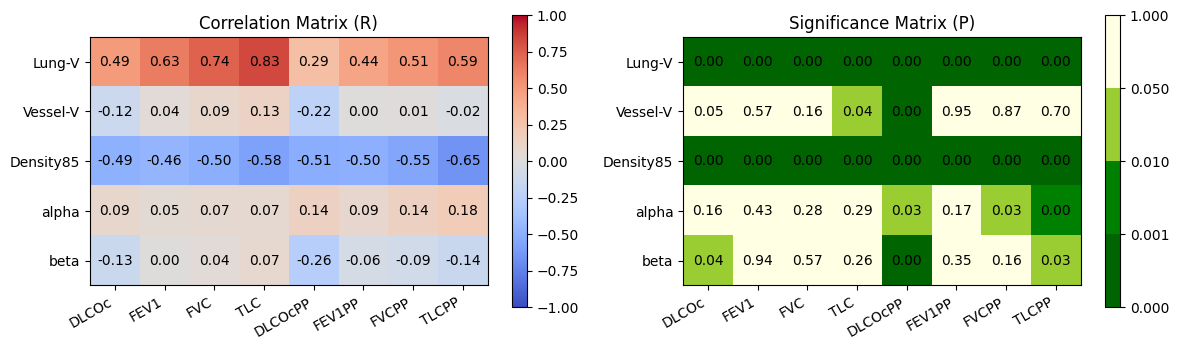

In [12]:
corr_p_imshow(corr_np_train, p_np_train, rows=biomarker_names, cols=pft_names)

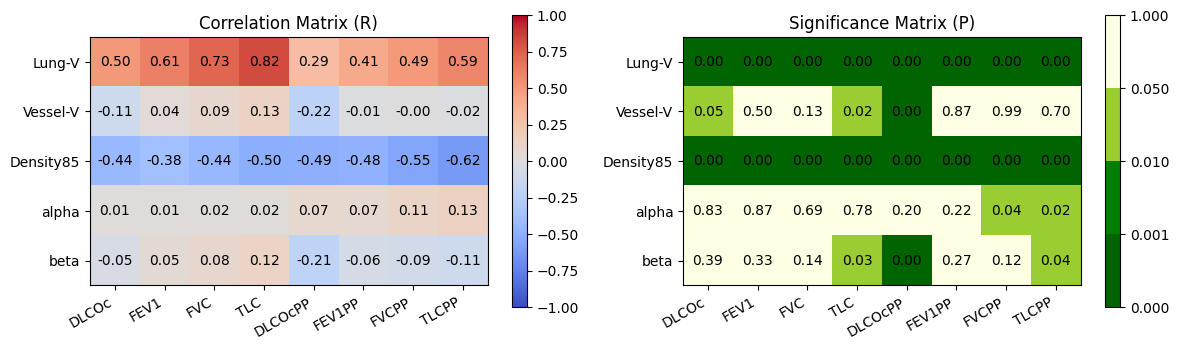

In [24]:
corr_p_imshow(corr_np_all, p_np_all, rows=biomarker_names, cols=pft_names)

# draw triangles table heat map

In [29]:
def heatmap(data, row_labels, col_labels, ax=None, cmap=None, bounds_p=None,norm_p=None, 
            cbar_kw=None, cbarlabel="", colorbar_pos='left', fig=None, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    colorbar_pos
        'left', 'right', 'bottom', 'top'
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    if np.min(data) < 0:
        im = ax.imshow(data, vmin = -1, vmax =1, **kwargs)
    else:
        im = ax.imshow(data, vmin = 0, vmax =1, **kwargs)

    # Create colorbar
    
    gap=0.01
    width_bar = 0.05
    if colorbar_pos == 'right':
        orientation='vertical'
        cax = fig.add_axes([ax.get_position().x1+gap,                   ax.get_position().y0,       width_bar,                  ax.get_position().height])
        # cax = fig.add_subplot(111)
    elif colorbar_pos == 'left':
        orientation='vertical'
        cax = fig.add_axes([ax.get_position().x0 - gap - width_bar, ax.get_position().y0,       width_bar,                  ax.get_position().height])
    elif colorbar_pos == 'top':
        orientation='horizontal'
        cax = fig.add_axes([ax.get_position().x0,                   ax.get_position().y1+gap,   ax.get_position().width,    width_bar])
    elif colorbar_pos == 'bottom':
        orientation='horizontal'
        cax = fig.add_axes([ax.get_position().x0,                   ax.get_position().y0-width_bar-gap,   ax.get_position().width,    width_bar])
        
    if type(cmap) is not str:
        cbar = ax.figure.colorbar(im, cax=cax, orientation=orientation, cmap=cmap, norm=norm_p, boundaries=bounds_p, ticks=bounds_p, shrink=0.8)
    else:
        cbar = ax.figure.colorbar(im, cax=cax, orientation=orientation) # Similar to fig.colorbar(im, cax = cax)
    
    


    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    # from mpl_toolkits.axes_grid1 import make_axes_locatable

    # divider = make_axes_locatable(ax)
    
    
    # if colorbar_pos in ['bottom', 'top']:
    #     cax = divider.append_axes(colorbar_pos, size="4%", pad=0.1)
    #     orientation='horizontal'
    # else:
    #     cax = divider.append_axes(colorbar_pos, size="4%", pad=0.1)
    #     orientation='vertical'
    # cbar = ax.figure.colorbar(im, cax=cax, orientation=orientation)
    

    # cbar = ax.figure.colorbar(im, ax=ax, location=colorbar_pos,  **cbar_kw)
    
    # cbar.ax.set_ylabel(cbarlabel)
    # if colorbar_pos in ['left', 'right']:
    
    if colorbar_pos=='right':
        cbar.ax.set_ylabel(cbarlabel, rotation=90, va="center", fontsize=12, labelpad=10)
    elif colorbar_pos=='left':
        cbar.ax.set_ylabel(cbarlabel, rotation=0, va="center")
    elif colorbar_pos=='bottom':
        cbar.ax.set_xlabel(cbarlabel, rotation=0, va="top", fontsize=12)
    elif colorbar_pos=='top':
        cbar.ax.set_xlabel(cbarlabel, rotation=0, va="center")
    else:
        raise Error('wrong pos')

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=30, ha="left",
    #          rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.spines[['right','left','bottom', 'top']].set_visible(True)
    ax.spines.top.set(visible=True)
    ax.spines.bottom.set(visible=True)
    ax.spines.left.set(visible=True)
    ax.spines.right.set(visible=True)
    
    # cax.spines[['right','left','bottom', 'top']].set_visible(True)
    # cax.spines.top.set(visible=True)
    # cax.spines.bottom.set(visible=True)
    # cax.spines.left.set(visible=True)
    # cax.spines.right.set(visible=True)
    # 调整布局
    # plt.subplots_adjust(left=0.1, right=0.6, top=0.9, bottom=0.1)
    # Adjust x-axis margins
    # plt.tight_layout()
    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if isinstance(data[i, j], np.ma.core.MaskedConstant):
                pass
            else:
                cell_text = data[i, j]
                # if float(cell_text) < 0.01
                text = im.axes.text(j, i, valfmt(cell_text, None), **kw)
                texts.append(text)

    return texts

In [30]:
def rplot(matrix: pd.DataFrame, title: str):
    
    # 定义自定义的colormap
    # cmap_p = matplotlib.colors.ListedColormap(['darkgreen', 'green', 'yellowgreen', '#ffffe4'])
    # bounds_p = [0, 0.001, 0.01, 0.05, 1]
    # norm_p = matplotlib.colors.BoundaryNorm(bounds_p, cmap_p.N)
    
    # # 绘制第二个
    # im2 = ax2.imshow(p_matrix, cmap=cmap_p, norm=norm_p)

    
    mask =  np.tri(len(matrix.columns.to_list()))
    corr_matrix = np.ma.masked_array(matrix, mask=mask.T)
    p_matrix = np.ma.masked_array(matrix, mask=mask)
    columns = matrix.columns.to_list()
    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    
    im, cbar = heatmap(corr_matrix, columns, columns, ax=ax, cmap="bwr", cbarlabel="Correlation coefficient (R)", colorbar_pos='bottom', fig=fig)
    texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=1)


    # im_p, cbar_p = heatmap(p_matrix, columns, columns, ax=ax, cmap=cmap_p, bounds_p=bounds_p,norm_p=norm_p,  cbarlabel="Significance (P)", colorbar_pos='right', fig=fig)
    # texts_p = annotate_heatmap(im_p, valfmt="{x:.2f}", threshold=1)

    # fig.tight_layout()
    ax.set_title(title)
    plt.show()


In [16]:
def rp_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # testing diseased data
    corr = df.corr(method=lambda x, y: pearsonr(x, y)[0])
    pvalues = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(df.columns)) 
    corr_and_p = rp_merge(corr, pvalues)
    return corr_and_p


def rp_merge(corr_test: pd.DataFrame, pvalues_test: pd.DataFrame) -> pd.DataFrame:
    corr_and_p_test = copy.deepcopy(corr_test)
    for i in range(len(corr_test)):
        for j in range(i+1, len(corr_test)):
            corr_and_p_test.iloc[i,j] = pvalues_test.iloc[i,j]
    return corr_and_p_test

In [17]:
# testing data
corr_and_p_test = rp_matrix(df_new[['DLCOc', 'FEV1', 'FVC', 'TLC']][252:])  #, 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'

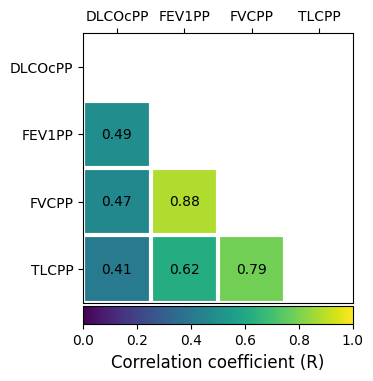

In [31]:
rplot(corr_and_p_test, '')


In [19]:
corr_and_p_test = rp_matrix(df_new[['DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP']][252:])  #, 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'

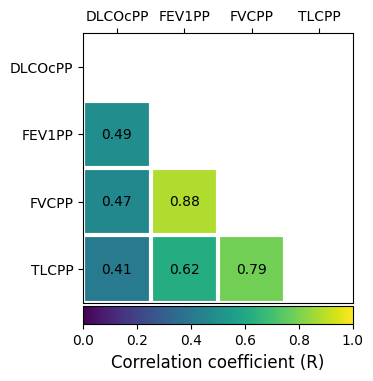

In [20]:
rplot(corr_and_p_test, '')


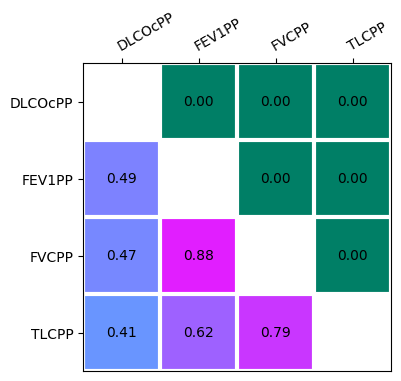

In [224]:
rplot(corr_and_p_test, '')


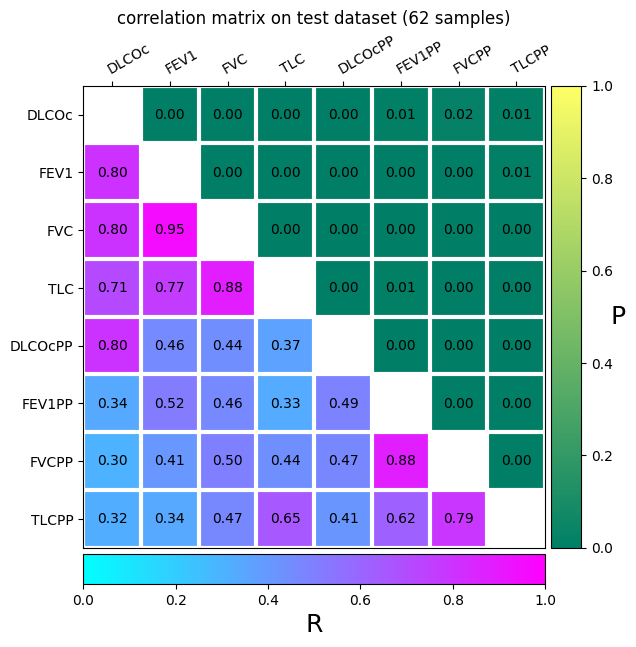

In [35]:
rplot(corr_and_p_test, 'correlation matrix on test dataset (62 samples)')


In [173]:
pat77_ids = ['9071115', '6503304', '6587088', '7852072', '0911478', '5112278', '9075756', '4125990',
                '0584534', '4945176', '3034278', '2712128', '1043946', '9934096', '5240010', '7135410',
                '7421048', '9367440', '5576984', '0152440', '3154090', '1160750', '6484444', '1105441',
                '4628660', '4171220', '1146160', '2131790', '0163750', '2151769', '5174713', '8365740',
                '2524918', '9239682', '3243752', '2341332', '7234834', '9160660', '5262908', '2253442',
                '0992750', '3567342', '5271048', '8278747', '9662556', '0222357', '8229975', '0139552',
                '3901150', '9300979', '0298877', '3228438', '8960279', '4107789', '7740702', '7252792',
                '8303176', '8492153', '5299407', '7957098', '1499510', '5323286', '5325396', '3310402',
                '5813928', '6122288', '0315573', '2346390', '5869896', '0280727', '5352138', '8353193',
                '5321814', '6329587', '1397732', '0458234', '9241693']


In [175]:
def filter_df(df, include_id_ls: list = None, exclude_id_ls: list = None):
    df_new = pd.DataFrame(columns=df.columns)
    for idx, row in df.iterrows():
        if include_id_ls is not None:
            if row['PatID'] in include_id_ls:
                df_new.loc[idx] = row
        elif exclude_id_ls is not None:
            if row['PatID'] not in exclude_id_ls:
                df_new.loc[idx] = row 
        else:
            raise Exception("include_id_ls and exclude_id_ls are all None")
    return df_new
            

In [177]:
df_healthy_test = filter_df(df_new[252:], include_id_ls=pat77_ids)
df_diseased_test = filter_df(df_new[252:], exclude_id_ls=pat77_ids)

In [178]:
corr_and_p_test_healthy = rp_matrix(df_healthy_test)
corr_and_p_test_diseased = rp_matrix(df_diseased_test)

ValueError: Unable to coerce to DataFrame, shape must be (0, 0): given (15, 15)

In [179]:
df_healthy = filter_df(df_new, include_id_ls=pat77_ids)
df_diseased = filter_df(df_new, exclude_id_ls=pat77_ids)
corr_and_p_healthy = rp_matrix(df_healthy)
corr_and_p_diseased = rp_matrix(df_diseased)
rplot(corr_and_p_healthy, 'correlation matrix on healthy dataset (77 samples)')
rplot(corr_and_p_diseased, 'correlation matrix on diseased dataset (237 samples)')


ValueError: Unable to coerce to DataFrame, shape must be (0, 0): given (15, 15)